# The diffusion equation

Previously, we discussed random walks and showed that the distribution of a walker who steps right with probability $p$ and left otherwise obeys the relation

<br><font color=orange size=5>
$$
P(x|n+1) = pP(x-1|n) + (1-p)P(x+1|n)
$$
</font><br> 

This relation is discrete both in time (number of steps) and space (lattice points $x$), In reality, molecules move continously in time and space. We will relax this assumptions and study what happens when we make the time and space discretization finer and finer. Mathematically, we can take this to the infinitessimal limit, when treating problems numerically, we need to maintain some level of discreteness. 

We will start by making the time steps smaller. 

Instead of steps $n=1,2,3,\ldots$ consider a continuous time variable $t$ and rates $r$ and $l$ to hop right or left. Rates have the dimension 1/time and products of rates and time intervals are dimensionless. The probability that the particle hops right in a small time interval $\Delta t$ is therefore $r\Delta t$. With probability $1-(r+l)\Delta t$ nothing happens.

![image.png](figures/RW_distribution_1d.png)

The above equation then becomes

$$
P(x|t+\Delta t) = \overbrace{(1-(r+l)\Delta t) P(x|t)}^{\mathrm{nothing\, happens}} + \underbrace{r\Delta t P(x-1|t)}_{\mathrm{hop\, right}} + \overbrace{l\Delta t P(x+1|t)}^{\mathrm{hop\, left}}
$$

We now subtract $\Delta t P(x|t)$ and divide by $\Delta t$ to obtain:

$$
\frac{P(x|t+\Delta t) - P(x|t)}{\Delta t} = \overbrace{-(r+l) P(x|t)}^{\mathrm{hop\,out}} + \underbrace{rP(x-1|t)}_{\mathrm{hop\,in\, right}} + \overbrace{l P(x+1|t)}^{\mathrm{hop\,in\,left}}
$$

The left hand side of the equation above is a discrete derivative and turn into $\frac{dP(x|t)}{ dt}$ if we take the limit $\Delta t \to 0$.

$$
\frac{dP(x|t)}{dt} = r \left[P(x-1|t) - P(x|t)\right] + l \left[P(x+1|t) - P(x|t)\right]
$$

For each value of $x$ we have thus obtained a differential equation that couples neighboring points in space! 

### Initial conditions
We can solve this equation numerically starting from an initial condition 

$$
P(x|0) = \begin{cases}
1 & x=0\\
0 & \mathrm{otherwise}
\end{cases}
$$

![image.png](figures/RW_distribution_initial.png)

We will often restrict our analysis to a region $x \in [x_{min}, x_{max}]$ -- we will look at the boundary effects more later.

### Solving the random walk dynamics in continuous time


In [32]:
import numpy as np
import matplotlib.pyplot as plt
# define the domain
xmin = -100
xmax = 101
x = np.arange(xmin, xmax)

#print("array of positions:", x)
print("center region of array (entries 98--102):", x[98:103])
print(f"initial position entry {-xmin}:", x[-xmin])

center region of array (entries 98--102): [-2 -1  0  1  2]
initial position entry 100: 0


Text(0, 0.5, 'P(x)')

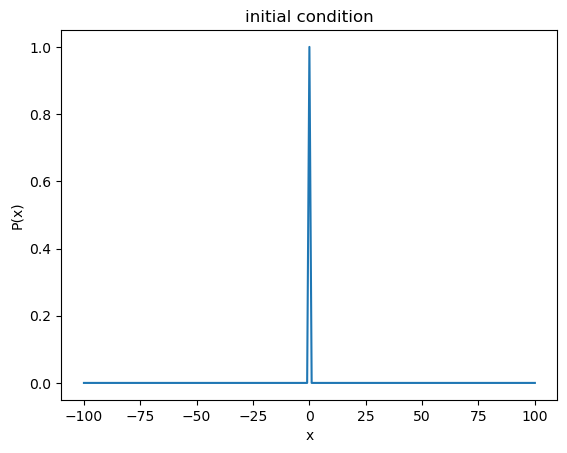

In [33]:
# make an array with the initial condition
p = np.zeros_like(x, dtype=float)
p[100] = 1 # this position corresponds to x=0

plt.plot(x, p)
plt.title('initial condition')
plt.xlabel('x')
plt.ylabel('P(x)')

In [34]:
# define the hopping rates. Note these have units 1/time and don't need to add up to one
r = 0.2
l = 0.3

# define the derivative
def dpdt(p, r, l):
    dp = []
    # deal with the left boundary, xmin: only hopping to the right
    dp.append(l*p[1] - r*p[0])
    #loop over all positions that are not at the boundary (not the first, not the last)
    for i in range(1,len(p)-1): 
        dp.append(r*(p[i-1] - p[i]) + l*(p[i+1] - p[i]))

    dp.append(r*p[-2] - l*p[-1])
    
    return np.array(dp)


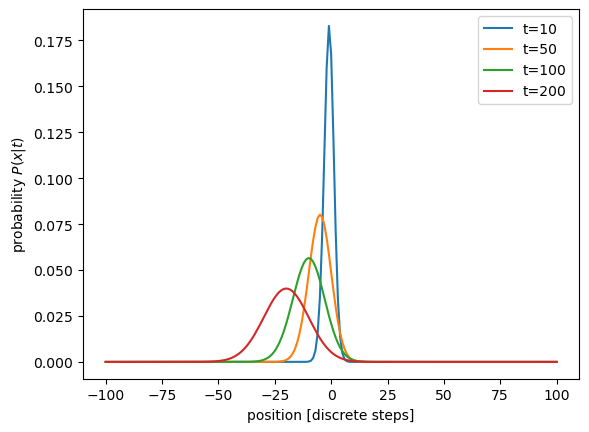

In [35]:
# the actual solution of the equation
dt = 0.01
t=0
for tmax in [10,50,100,200]:
    while (t<tmax):
        p += dt*dpdt(p,r,l)
        t += dt
    plt.plot(x,p, label=f't={tmax}')

plt.xlabel('position [discrete steps]')
plt.ylabel('probability $P(x|t)$')
plt.legend()

### The above implementation is slow

The reason for this slowness is that we are have two nested loops, one over the time steps and within `dpdt` one over the positions. In a language like python, this is inefficient. 

But we can speed this up by a lot when using arrays. Arrays are lists of objects that all have the same type (numbers in our case) and there are efficient functions that can operate on arrays by applying the same operations to every element. In our case, we want to do an operation like

`r*(p[i-1] - p[i]) + l*(p[i+1] - p[i])` 

on the entire array (besides the boundary elements). 

The layout of the array `p` is the following. 
```
index:  0  1  2  3  4  5  6  7  8  9
value: p0 p1 p2 p3 p4 p5 p6 p7 p8 p9
```
Knowing this layout, we can recast the operation above like
```
p[1:-1]: p1 p2 p3 p4 p5 p6 p7 p8  | *-(r+l)
p[0:-2]: p0 p1 p2 p3 p4 p5 p6 p7  | * r
p[2:]:   p2 p3 p4 p5 p6 p7 p8 p9  | * l
```
and sum over every column of the matrix. This is achieved by 

`r*(p[0:-2] - p[1:-1]) + l*(p[2:] - p[1:-1])`

and calculates `dpdt` for all indices other than the first and the last. These two we still have to deal with separately, but almost all values can be handled in this vectorized form, which is much faster. 

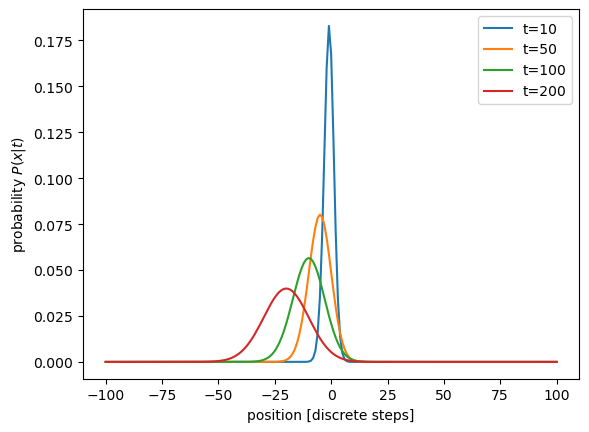

In [38]:
# make an array with the initial condition
p = np.zeros_like(x, dtype=float)
p[100] = 1 # this position corresponds to x=0

# define the hopping rates. Note these have units 1/time and don't need to add up to one
r = 0.2
l = 0.3

# define the derivative
def dpdt(p, r, l):
    dp = np.zeros_like(p)
    # for an array a=[0,1,2,3,4], a[1:] is [1,2,3,4] (everything but the first)
    # and a[:-1] is [0,1,2,3] (everything but the last)
    dp[1:-1] += r*(p[:-2] - p[1:-1]) + l*(p[2:] - p[1:-1])
    dp[0] += l*p[1] - r*p[0]
    dp[-1] += r*p[-2] - l*p[-1]
    
    return dp

# the actual solution of the equation
dt = 0.01
t=0
for tmax in [10,50,100,200]:
    while (t<tmax):
        p += dt*dpdt(p,r,l)
        t += dt
    plt.plot(x,p, label=f't={tmax}')

plt.xlabel('position [discrete steps]')
plt.ylabel('probability $P(x|t)$')
plt.legend()

## Taking the continuous limit in space

Above, we took the discrete update rules for a random walk on discrete lattice points and turned this into an equation that describes the evolution of the probability distribution in continuous time. Now, we will tackle the problem of reducing the lattice spacing and take the continuum limit in space. Let's just take the equation from above and replace $\pm 1$ by $\pm \delta x$

$$
\frac{\partial P(x|t)}{\partial t} = r \left[P(x-\delta x|t) - P(x|t)\right] + l \left[P(x+\delta x|t) - P(x|t)\right]
$$

We want to treat $P(x|t)$ as a continuous function of $x$ and consider smaller and smaller $\delta x$. Once $\delta x$ is small enough, we can approximate $P(x\pm \delta x|t)$ by its [Taylor series](https://en.wikipedia.org/wiki/Taylor_series)

$$
P(x\pm \delta x|t) = P(x|t) \pm \delta x \frac{\partial P(x|t)}{\partial x} + \frac{\delta x^2}{2} \frac{\partial^2 P(x|t)}{\partial x^2} + \cdots
$$

Before substituting this into the above equation, not that all terms proportional to $P(x|t)$ disappear. 
Further note that the left/right terms proportional to $\frac{\partial P(x|t)}{\partial x}$ have opposite signs, while those proportional to $\frac{\partial^2 P(x|t)}{\partial x^2}$ have the same sign. 

This then combines to the following expression

$$
\frac{\partial P(x|t)}{\partial t} = (r+l)\frac{\delta x^2 }{2}\frac{\partial^2 P(x|t)}{\partial x^2} + (l-r)\delta x \frac{\partial P(x|t)}{\partial x}
$$

Now remember that $r$ and $l$ were the rate at which the particle hops left or right a distance $\delta x$. Now that we are changing $\delta x$ and considering the limit of smaller and smaller $\delta x$, we need to adjust $r$ and $l$. 
Ultimately, we want a description that does not depend on the arbitrary choice of $\delta x$ we have made and we have to realize that $r$ and $s$ were just auxillary quantities tied to the discretization.
Defining the diffusion constant $D$ and the velocity $v$ as

<br><font color=red>
$$
D = \frac{(r+l)\delta x^2}{2} \quad \mathrm{and}\quad v = (r-l)\delta x
$$
</font><br>

we obtain the diffusion equation

<br><font color=red size=5>
$$
\frac{\partial P(x|t)}{\partial t} = D\frac{\partial^2 P(x|t)}{\partial x^2} - v\frac{\partial P(x|t)}{\partial x}
$$
</font><br>

Note that the rate $r$ and $l$ we initially defined are rates and have units of 1/time. The diffusion constant therefore has units $\mathrm{length}^2/\mathrm{time}$ and the velocity $v$ has units of $\mathrm{length}/\mathrm{time}$.

![image.png](figures/diffusion_curvature.png)

## Solution of the diffusion equation

Depending on the initial conditions and the boundary conditions, there are different approaches to solving the diffusion equation. We will first tackle the case where we initially know exactly that all molecules are concentrated in a very small space and can diffuse without limits, like injecting a small drop of coloring to the a hugh still tank of water. In this case, the solution is

<font color=orange size=5>
$$
P(x|t) = \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-vt)^2}{4Dt}}
$$
</font>

This curve is a Gaussian curve with mean and variance 

<font color=orange>
$$
\mathrm{mean} = vt \quad \mathrm{and} \quad \mathrm{variance}=2Dt
$$
</font><br>

 * The center of the distribution translates at constant speed $v$
 * The width of the distribution increases as $\sqrt{2Dt}$. 
 
Note the direct correspondence between this behavior and what we observed in the discrete case for the binomial distribution. 

Text(0, 0.5, 'probability density')

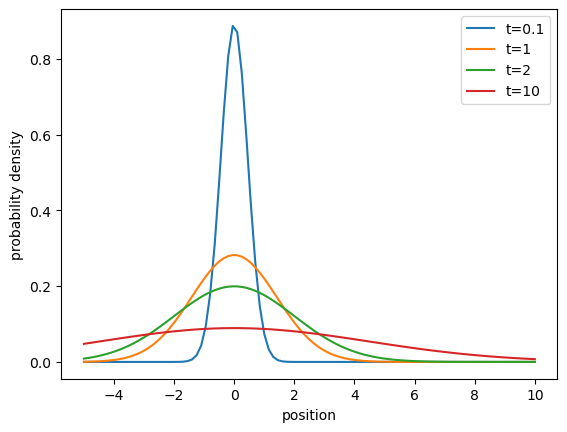

In [39]:
# Plotting the solution to the diffusion equation
D = 1.0 # dimension length^2/time
v = 0.0  # dimension length/time

def gauss_solution(x, t, v, D):
    return 1/np.sqrt(4*D*np.pi*t)*np.exp(-(x-v*t)**2/(4*D*t))

# array of 101 points between -5 and 10
x = np.linspace(-5,10,101)

for t in [0.1, 1, 2, 10]:
    plt.plot(x, gauss_solution(x, t, v, D), label=f"t={t}")

plt.legend()
plt.xlabel("position")
plt.ylabel("probability density")

## Change v and D to see the resulting changes. 


## Numerical solution to the diffusion equation
In many situations, we will need to solve the diffusion equation numerically. There are complex algorithms out there to solve such partial differential equations, but we will follow a simpler, more intuitve, but less accurate approach. **We will undo the continuous limit and solve it in discrete time and space.**

So starting with equation

$$
\frac{\partial P(x|t)}{\partial t} = D\frac{\partial^2 P(x|t)}{\partial x^2} - v\frac{\partial P(x|t)}{\partial x}
$$

in continuous time and space. 

If we discretize space in steps of $\delta x$, the right hand side of this equation corresponds our equation above:  

$$
\frac{\partial P(x|t)}{\partial t} = r \left[P(x-\delta x|t) - P(x|t)\right] + l \left[P(x+\delta x|t) - P(x|t)\right]
$$

where $r$ and $l$ are related to $D$ and $v$ via

$$
D = \frac{(r+l)\delta x^2}{2} \quad \mathrm{and}\quad v = (r-l)\delta x
$$

We can solve these for $r$ and $l$ as

$$
r = \frac{D}{\delta x^2} + \frac{v}{2\delta x} \quad l = \frac{D}{\delta x^2} - \frac{v}{2\delta x}
$$

In [40]:
# define the derivative
def dpdt(p, r, l):
    dp = np.zeros_like(p)
    dp[1:-1] += r*(p[:-2] - p[1:-1])  # jump to the right
    dp[1:-1] += l*(p[2:] - p[1:-1]) # jump to the left
    dp[0] += l*p[1] - r*p[0]        # deal with the first point separately 
    dp[-1] += r*p[-2] - l*p[-1]     # deal with the last point separately

    return dp

In [41]:
# define parameters and left/right hopping rates
D = 1
v = 0.0
dx = 0.2     # if dx is too small, numerical solution is unstable
dt = 0.005  # if dt is too large, numerical solution is unstable

r = D/dx**2 + v/dx/2
l = D/dx**2 - v/dx/2
print("left/right rates:", r, l)


left/right rates: 24.999999999999996 24.999999999999996


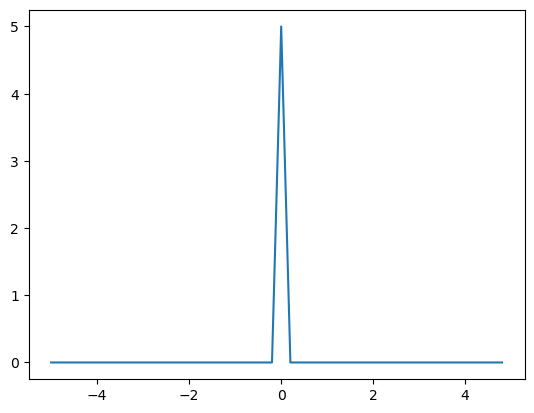

In [42]:

# set up the initial condition
x = np.arange(-5,5,dx)
p = np.zeros_like(x)
p[len(x)//2] = 1/dx   # a peak at x=0 with weight 1/dx (total area =1)

plt.plot(x,p)

Text(0.5, 0, 'position')

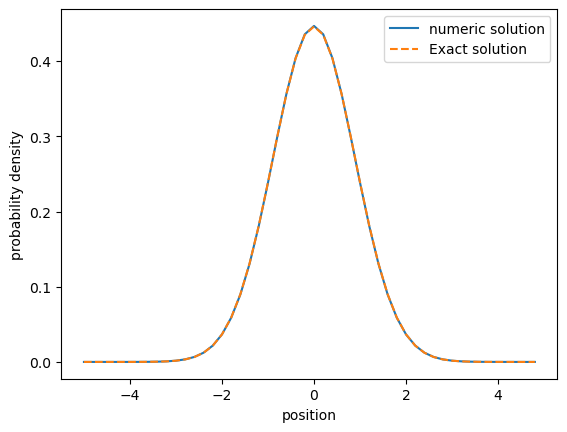

In [43]:
# solve the equation using the forward Euler method
tmax = 0.4
t=0
while t<tmax:
    p += dt*dpdt(p, r, l)
    t += dt

# plot the result
plt.plot(x,p, label="numeric solution")
plt.plot(x, gauss_solution(x, tmax, v, D), ls='--', label='Exact solution') 
plt.legend()
plt.ylabel('probability density')
plt.xlabel('position')

As you see, the numerical solution matches the exact one! And we get this match for different choices of $\delta x$ and $\delta t$ as long as $\delta t$ is sufficiently small and $\delta x$ is sufficiently large. 

We will use such numerical solutions repeatedly throughout the course. So it is worth going through this in some detail.

#### Dig deeper
 * In some limits the binomial distribution is well approximated by the Gaussian distribution. What are the similarities between the distributions? When is the discrete nature of steps in the binomial important, when isn't it? Read up on the central limit theorem!
 * If you sum independently distributed random variables, means and variances are additive. How does this relate to the behavior of the diffusion process?
 * Verify the expression of $r$ and $l$ as a function of $D$ and $v$. $D$ increases quadratically with $\delta x$. Why is that? Why doesn $v$ only increase linearly with $\delta x$.
 * Verify that the Gaussian distribution solves the diffusion equation.